In [ ]:
# Warm up
# 

import math
math.exp(-500)

7.124576406741286e-218

In [26]:
import numpy as np
import random
import math

# -------------------------------------------------
# Cost matrix from the slide (index 0-based)
# -------------------------------------------------
C = np.array([
    [ 0,  5,  3,  1,  4, 12],
    [ 2,  0, 22, 11, 13, 30],
    [ 6,  8,  0, 13, 12,  5],
    [33,  9,  5,  0, 60, 17],
    [ 1, 15,  6, 10,  0, 14],
    [24,  6,  8,  9, 40,  0]
])

n_cities   = C.shape[0]
iters      = 100_000         # total annealing steps
T0         = 1.0             # initial “temperature”
cooling    = lambda k: T0 / math.sqrt(1 + k)      # T_k

# -------------------------------------------------
# Helper: total cost of a (closed) tour
# -------------------------------------------------
def tour_cost(tour):
    s = 0
    for a, b in zip(tour, tour[1:]):
        s += C[a, b]
    s += C[tour[-1], tour[0]]      # return to start
    return s

# -------------------------------------------------
# Initial state: random permutation (must start at 0)
# -------------------------------------------------
current = [0] + random.sample(range(1, n_cities), n_cities - 1)
best_tour  = current[:]
best_cost  = tour_cost(current)

# -------------------------------------------------
# Simulated annealing loop
# -------------------------------------------------
cost_trace = []

for k in range(1, iters + 1):

    # --- 1. propose: swap two *non-zero* positions (0 is fixed) ----
    i, j = random.sample(range(1, n_cities), 2)
    candidate = current[:]
    candidate[i], candidate[j] = candidate[j], candidate[i]

    # --- 2. compute Δ  (candidate – current) ----------------------
    curr_cost = tour_cost(current)
    cand_cost = tour_cost(candidate)
    delta     = cand_cost - curr_cost

    # --- 3. acceptance rule ---------------------------------------
    if delta <= 0:                          # better → take it
        current = candidate
    else:
        T = cooling(k)
        if random.random() < math.exp(-delta / T):
            current = candidate             # accept uphill move

    # --- 4. keep best ever ----------------------------------------
    if cand_cost < best_cost:
        best_cost, best_tour = cand_cost, candidate

    # --- optional: trace ------------------------------------------
    cost_trace.append(best_cost)

# -------------------------------------------------
# Results
# -------------------------------------------------
print("Best route found:", best_tour + [best_tour[0]])
print("Total cost      :", best_cost)

Best route found: [0, 4, 5, 3, 2, 1, 0]
Total cost      : 42


(a) random    best length ≈   3.44
(b) circle    best length ≈   6.18


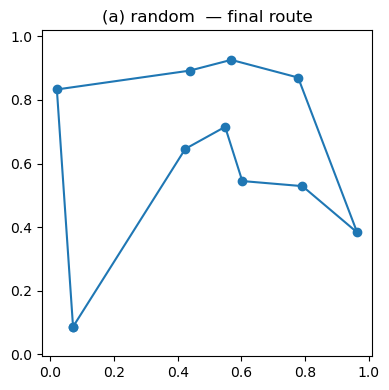

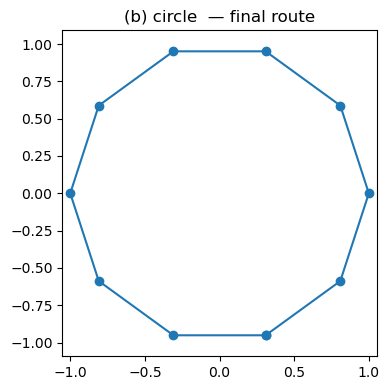

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1)  helper functions
# ------------------------------------------------------------
def euclidean(a, b):
    """Straight-line distance between two 2-D points."""
    return np.linalg.norm(a - b, axis=1)

def route_length(route, coords):
    """Total length of closed tour given permutation route."""
    p = coords[route]
    return euclidean(p, np.roll(p, -1, axis=0)).sum()

def two_swap(route):
    """Proposal: swap two DISTINCT inner indices of the tour."""
    n = len(route) - 1       # last city duplicates the first
    i, j = np.random.choice(np.arange(1, n), size=2, replace=False)
    route[i], route[j] = route[j], route[i]
    return route

# ------------------------------------------------------------
# 2)  simulated–annealing core
# ------------------------------------------------------------
def sim_ann(coords, iters=20_000):
    n = len(coords)
    # initial random permutation, doubled end-point
    route = np.arange(n)
    np.random.shuffle(route)
    route = np.append(route, route[0])

    best = route.copy()
    L_best = route_length(best, coords)

    for k in range(1, iters + 1):
        T = 1.0 / np.sqrt(1 + k)          # cooling schedule
        cand = two_swap(route.copy())
        Δ = route_length(cand, coords) - route_length(route, coords)

        if Δ <= 0 or np.random.rand() < np.exp(-Δ / T):
            route = cand

        if Δ < 0 and route_length(route, coords) < L_best:
            best, L_best = route.copy(), route_length(route, coords)

    return best, L_best

# ------------------------------------------------------------
# 3)  run twice: (a) random square, (b) circle debug
# ------------------------------------------------------------
np.random.seed(0)

for label, coords in {
        "(a) random": np.random.rand(10, 2),
        "(b) circle": np.column_stack([np.cos(np.linspace(0, 2*np.pi, 10, endpoint=False)),
                                       np.sin(np.linspace(0, 2*np.pi, 10, endpoint=False))])
    }.items():

    tour, length = sim_ann(coords, iters=20000)
    print(f"{label:12}  best length ≈ {length:6.2f}")

    # ---- plot ----
    plt.figure(figsize=(4,4))
    plt.plot(coords[tour, 0], coords[tour, 1], '-o')
    plt.title(f"{label}  — final route")
    plt.axis('equal'); plt.tight_layout()

plt.show()

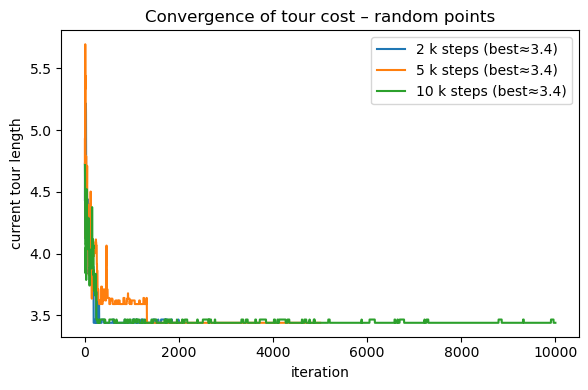

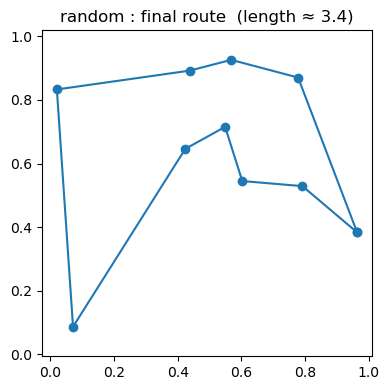

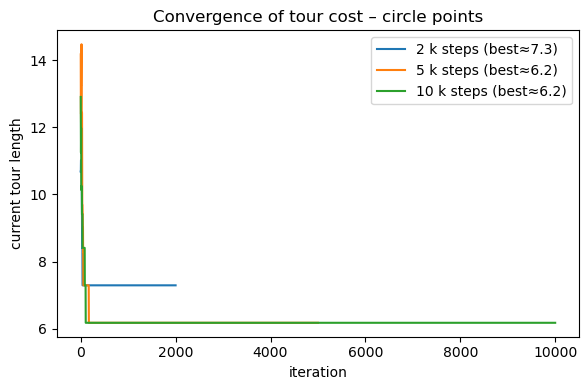

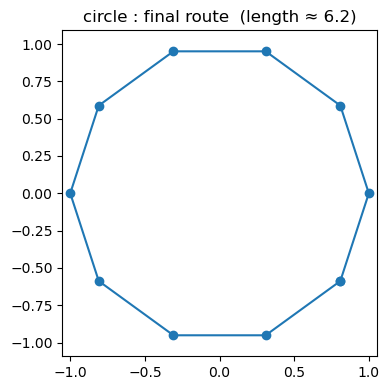

In [ ]:
# ------------------------------------------------------------
# Simulated-annealing TSP demo
#  – adds a **convergence plot** of the path-cost versus iteration
#    for three different run lengths (2 k, 5 k, 10 k steps)
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# helpers
# ------------------------------------------------------------
def euclidean(a, b):
    """Pairwise straight-line distance between two 2-D points arrays a,b (shape (n,2))."""
    return np.linalg.norm(a - b, axis=1)

def tour_length(tour, coords):
    """Total perimeter of closed tour   coords[tour] ."""
    p = coords[tour]
    return euclidean(p, np.roll(p, -1, axis=0)).sum()

def two_swap(tour):
    """Swap two distinct *inner* cities (leave start/end fixed)."""
    n = len(tour) - 1           # last duplicates first
    i, j = np.random.choice(np.arange(1, n), size=2, replace=False)
    tour[i], tour[j] = tour[j], tour[i]
    return tour

# ------------------------------------------------------------
# core simulated-annealing routine
# ------------------------------------------------------------
def sim_ann(coords, iters=10_000):
    n = len(coords)
    # random closed tour
    perm  = np.random.permutation(n)
    tour  = np.append(perm, perm[0])           # repeat start at end
    best  = tour.copy()
    Lbest = tour_length(best, coords)

    costs = []                                 # convergence trace

    for k in range(1, iters + 1):
        T = 1.0 / np.sqrt(1 + k)               # cooling schedule
        cand = two_swap(tour.copy())
        Δ    = tour_length(cand, coords) - tour_length(tour, coords)

        if Δ <= 0 or np.random.rand() < np.exp(-Δ / T):
            tour = cand                        # accept

        Lcurr = tour_length(tour, coords)
        costs.append(Lcurr)

        if Lcurr < Lbest:
            best, Lbest = tour.copy(), Lcurr

    return best, Lbest, np.array(costs)

# ------------------------------------------------------------
# generate two data sets (random + circle) and run 3 lengths
# ------------------------------------------------------------
np.random.seed(0)
coord_sets = {
    "random": np.random.rand(10, 2),
    "circle": np.column_stack([np.cos(np.linspace(0, 2*np.pi, 10, endpoint=False)),
                               np.sin(np.linspace(0, 2*np.pi, 10, endpoint=False))])
}
steps_list = [2_000, 5_000, 10_000]

for name, coords in coord_sets.items():
    plt.figure(figsize=(6, 4))
    for steps in steps_list:
        _, best_len, trace = sim_ann(coords, iters=steps)
        plt.plot(trace, label=f"{steps//1000} k steps (best≈{best_len:.1f})")
    plt.title(f"Convergence of tour cost – {name} points")
    plt.xlabel("iteration");  plt.ylabel("current tour length")
    plt.legend();  plt.tight_layout()
    plt.show()

    # plot the final best route from the *longest* run
    best_route, best_len, _ = sim_ann(coords, iters=steps_list[-1])
    plt.figure(figsize=(4,4))
    plt.plot(coords[best_route,0], coords[best_route,1], '-o')
    plt.title(f"{name} : final route  (length ≈ {best_len:.1f})")
    plt.axis('equal');  plt.tight_layout();  plt.show()

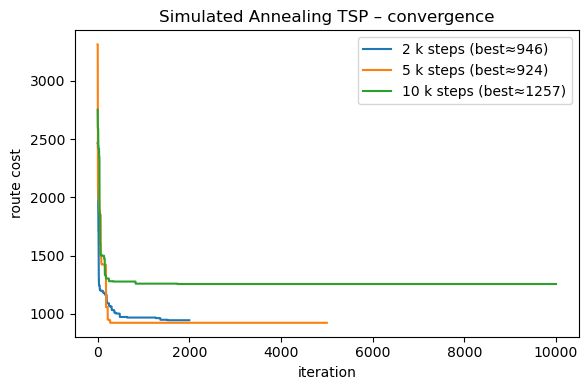

Best length: 818 
Best tour: [0, 12, 3, 5, 11, 17, 6, 16, 10, 19, 2, 4, 7, 15, 9, 18, 14, 1, 8, 13, 0]


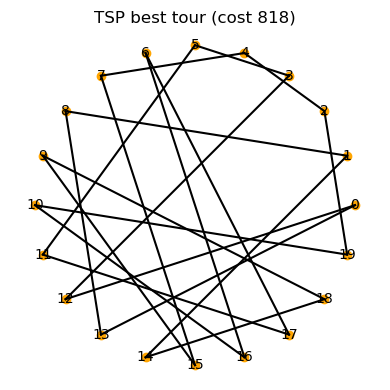

In [3]:
# ---------------------------------------------------------------------
#  Simulated Annealing for the TSP – **part (b)**
#  • Works directly on a *given cost matrix* (no co-ordinates needed)
#  • Generates the same two figures as before:
#      1.  Convergence of the route cost for three run-lengths
#      2.  The final best route found in the longest run
# ---------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1.  Read the 20 × 20 cost matrix that you pasted in the prompt
# ------------------------------------------------------------
raw = """\
0,225,110,8,257,22,83,231,277,243,94,30,4,265,274,250,87,83,271,86
255,0,265,248,103,280,236,91,3,87,274,265,236,8,24,95,247,259,28,259
87,236,0,95,248,110,25,274,250,271,9,244,83,250,248,280,29,26,239,7
8,280,83,0,236,28,91,239,280,259,103,23,6,280,244,259,95,87,230,84
268,87,239,271,0,244,275,9,84,25,244,239,275,83,110,24,274,280,84,274
21,265,99,29,259,0,99,230,265,271,87,5,22,239,236,250,87,95,271,91
95,236,28,91,247,93,0,247,259,244,27,91,87,268,275,280,7,8,240,27
280,83,250,261,4,239,230,0,103,24,239,261,271,95,87,21,274,255,110,280
247,9,280,274,84,255,259,99,0,87,255,274,280,3,27,83,259,244,28,274
230,103,268,275,23,244,264,28,83,0,268,275,261,91,95,8,277,261,84,247
87,239,9,103,261,110,29,255,239,261,0,259,84,239,261,242,24,25,242,5
30,255,95,30,247,4,87,274,242,255,99,0,24,280,274,259,91,83,247,91
8,261,83,6,255,29,103,261,247,242,110,29,0,261,244,230,87,84,280,100
242,8,259,280,99,242,244,99,3,84,280,236,259,0,27,95,274,261,24,268
274,22,250,236,83,261,247,103,22,91,250,236,261,25,0,103,255,261,5,247
244,91,261,255,28,236,261,29,103,9,242,261,244,87,110,0,242,236,95,259
84,236,27,99,230,83,7,259,230,230,22,87,93,250,255,247,0,9,259,24
91,242,28,87,250,110,6,271,271,255,27,103,84,250,271,244,5,0,271,29
261,24,250,271,84,255,261,87,28,110,250,248,248,22,3,103,271,248,0,236
103,271,8,91,255,91,21,271,236,271,7,250,83,247,250,271,22,27,248,0"""
cost_mat = np.array([[int(x) for x in row.split(',')] for row in raw.splitlines()])
n_cities = cost_mat.shape[0]

# ------------------------------------------------------------
# 2.  Cost function and proposal generator
# ------------------------------------------------------------
def tour_cost(tour, C):
    """Sum of costs along a closed TSP tour."""
    return C[tour[:-1], tour[1:]].sum()

def swap_two(tour):
    """Swap two inner cities (exclude index 0 which is repeated at end)."""
    i, j = np.random.choice(np.arange(1, len(tour)-1), 2, replace=False)
    tour[i], tour[j] = tour[j], tour[i]
    return tour

# ------------------------------------------------------------
# 3.  Simulated annealing core
# ------------------------------------------------------------
def anneal(C, steps):
    # random initial permutation (must start/end at 0)
    perm  = np.random.permutation(np.arange(1, n_cities))
    tour  = np.r_[0, perm, 0]             # closed path
    best  = tour.copy()
    bestL = tour_cost(best, C)

    trace = []
    for k in range(1, steps+1):
        T = 1/np.sqrt(1+k)                # cooling scheme
        cand = swap_two(tour.copy())
        Δ    = tour_cost(cand, C) - tour_cost(tour, C)

        if Δ <= 0 or np.random.rand() < np.exp(-Δ/T):
            tour = cand                   # accept move
        if (L := tour_cost(tour, C)) < bestL:
            best, bestL = tour.copy(), L
        trace.append(L)
    return best, bestL, np.array(trace)

# ------------------------------------------------------------
# 4.  Run three different lengths + build convergence plot
# ------------------------------------------------------------
run_lengths = [2_000, 5_000, 10_000]

plt.figure(figsize=(6,4))
for steps in run_lengths:
    _, best_len, tr = anneal(cost_mat, steps)
    plt.plot(tr, label=f"{steps//1000} k steps (best≈{best_len:.0f})")
plt.xlabel("iteration"); plt.ylabel("route cost")
plt.title("Simulated Annealing TSP – convergence")
plt.legend(); plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 5.  Show the final tour (longest run)
# ------------------------------------------------------------
best_route, best_len, _ = anneal(cost_mat, run_lengths[-1])
print("Best length:", best_len, "\nBest tour:", best_route.tolist())

plt.figure(figsize=(4,4))
# we don’t have coordinates, so draw a circular layout for illustration
angles = 2*np.pi*np.arange(n_cities)/n_cities
xs, ys = np.cos(angles), np.sin(angles)
for a,b in zip(best_route[:-1], best_route[1:]):
    plt.plot([xs[a], xs[b]], [ys[a], ys[b]], 'k-')
plt.scatter(xs, ys, c='orange')
for idx,(x,y) in enumerate(zip(xs,ys)): plt.text(x, y, str(idx), ha='center', va='center')
plt.title(f"TSP best tour (cost {best_len:.0f})"); plt.axis('equal'); plt.axis('off')
plt.tight_layout(); plt.show()

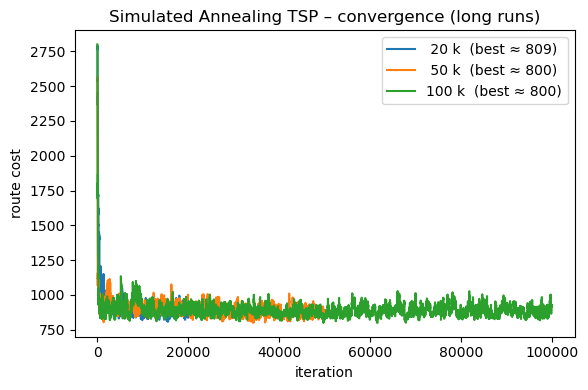

BEST LENGTH FOUND: 801


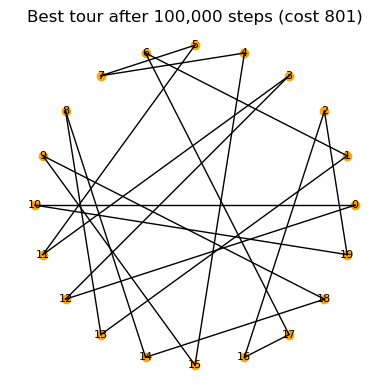

In [8]:
# ------------------------------------------------------------------
# Simulated-annealing TSP  –  longer runs / smoother cooling
# ------------------------------------------------------------------
def anneal_long(C, steps, T0=None):
    """Simulated annealing with log–cooling and longer schedule."""
    if T0 is None:
        # a reasonable start temperature: average edge-length
        T0 = C.mean()

    perm  = np.random.permutation(np.arange(1, n_cities))
    tour  = np.r_[0, perm, 0]
    best  = tour.copy()
    bestL = tour_cost(best, C)

    trace = []
    for k in range(1, steps + 1):
        T = T0 / np.log(k + 2)           # slower cooling than 1/√k
        cand = swap_two(tour.copy())
        Δ    = tour_cost(cand, C) - tour_cost(tour, C)

        if Δ <= 0 or np.random.rand() < np.exp(-Δ / T):
            tour = cand
        if (L := tour_cost(tour, C)) < bestL:
            best, bestL = tour.copy(), L
        trace.append(L)
    return best, bestL, np.array(trace)

# --------------------- run MUCH longer ----------------------------
run_lengths = [20_000, 50_000, 100_000]   # 20 k, 50 k, 100 k iterations

plt.figure(figsize=(6,4))
for steps in run_lengths:
    _, best_len, tr = anneal_long(cost_mat, steps)
    plt.plot(tr,               # trace
             label=f"{steps//1000:>3} k  (best ≈ {best_len:.0f})")
plt.xlabel("iteration")
plt.ylabel("route cost")
plt.title("Simulated Annealing TSP – convergence (long runs)")
plt.legend()
plt.tight_layout()
plt.show()

# --------------- show the best overall tour -----------------------
best_route, best_len, _ = anneal_long(cost_mat, run_lengths[-1])
print("BEST LENGTH FOUND:", best_len)

plt.figure(figsize=(4,4))
ang = 2*np.pi*np.arange(n_cities)/n_cities
xs, ys = np.cos(ang), np.sin(ang)
for a, b in zip(best_route[:-1], best_route[1:]):
    plt.plot([xs[a], xs[b]], [ys[a], ys[b]], 'k-', lw=1)
plt.scatter(xs, ys, c='orange')
for idx, (x, y) in enumerate(zip(xs, ys)):
    plt.text(x, y, str(idx), ha='center', va='center', fontsize=8)
plt.title(f"Best tour after {run_lengths[-1]:,} steps (cost {best_len:.0f})")
plt.axis('equal'); plt.axis('off'); plt.tight_layout(); plt.show()